In [1]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Laser Shooting Strategy 1

**Overview**
1. Find target position from image by using meter/pixel approximation from ar tags
2. Calculate angle to turn from target position using Trigonometry
3. Use result angle to turn astrobee x number of times base on how we handle navigation errors

## Target position

In [2]:
# CONSTANT
cam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258],
        [0.000000, 534.765913, 500.335102],
        [0.000000, 0.000000, 1.000000],
    ]
)
dist_coeffs = np.array([-0.164787, 0.020375, -0.001572, -0.000369, 0.000000])


def distance(x0, y0, x1, y1):
    return math.sqrt(pow(x1 - x0, 2) + pow(y1 - y0, 2))

### 1. Find target position on image
From this post [undistort-vs-undistortpoints-for-feature-matching-of-calibrated-images](https://stackoverflow.com/questions/30919957/undistort-vs-undistortpoints-for-feature-matching-of-calibrated-images) \
We should use `undistort` instead of `undistortPoint`

[opencv-undistort-cropped-image](https://stackoverflow.com/questions/68634072/opencv-undistort-cropped-image), this post tell how to undistort cropped image by using new principal point

In [3]:
def undistort_cropped(img, x: int, y: int):
    tcam_mat = np.array(
        [
            [523.105750, 0.000000, 635.434258 - x],
            [0.000000, 534.765913, 500.335102 - y],
            [0.000000, 0.000000, 1.000000],
        ]
    )
    res = cv2.undistort(img, tcam_mat, dist_coeffs)
    return res

In [4]:
# Image processing
crop_x = 500
crop_y = 500

img = cv2.imread(
    "../../Img/target2.png", cv2.IMREAD_GRAYSCALE
)  # reading image == api.getMatNavCam()
c_img = img[crop_y:700, crop_x:830].copy()  # cropped image (y:y+height, x:x+width)
ud_img = undistort_cropped(c_img, crop_x, crop_y)

In [5]:
# Finding circle
circle = cv2.HoughCircles(
    ud_img, cv2.HOUGH_GRADIENT, 1, 300, param1=50, param2=30, minRadius=40, maxRadius=50
)
center = circle[0][0]
center

array([172.5, 103.5,  45.4], dtype=float32)

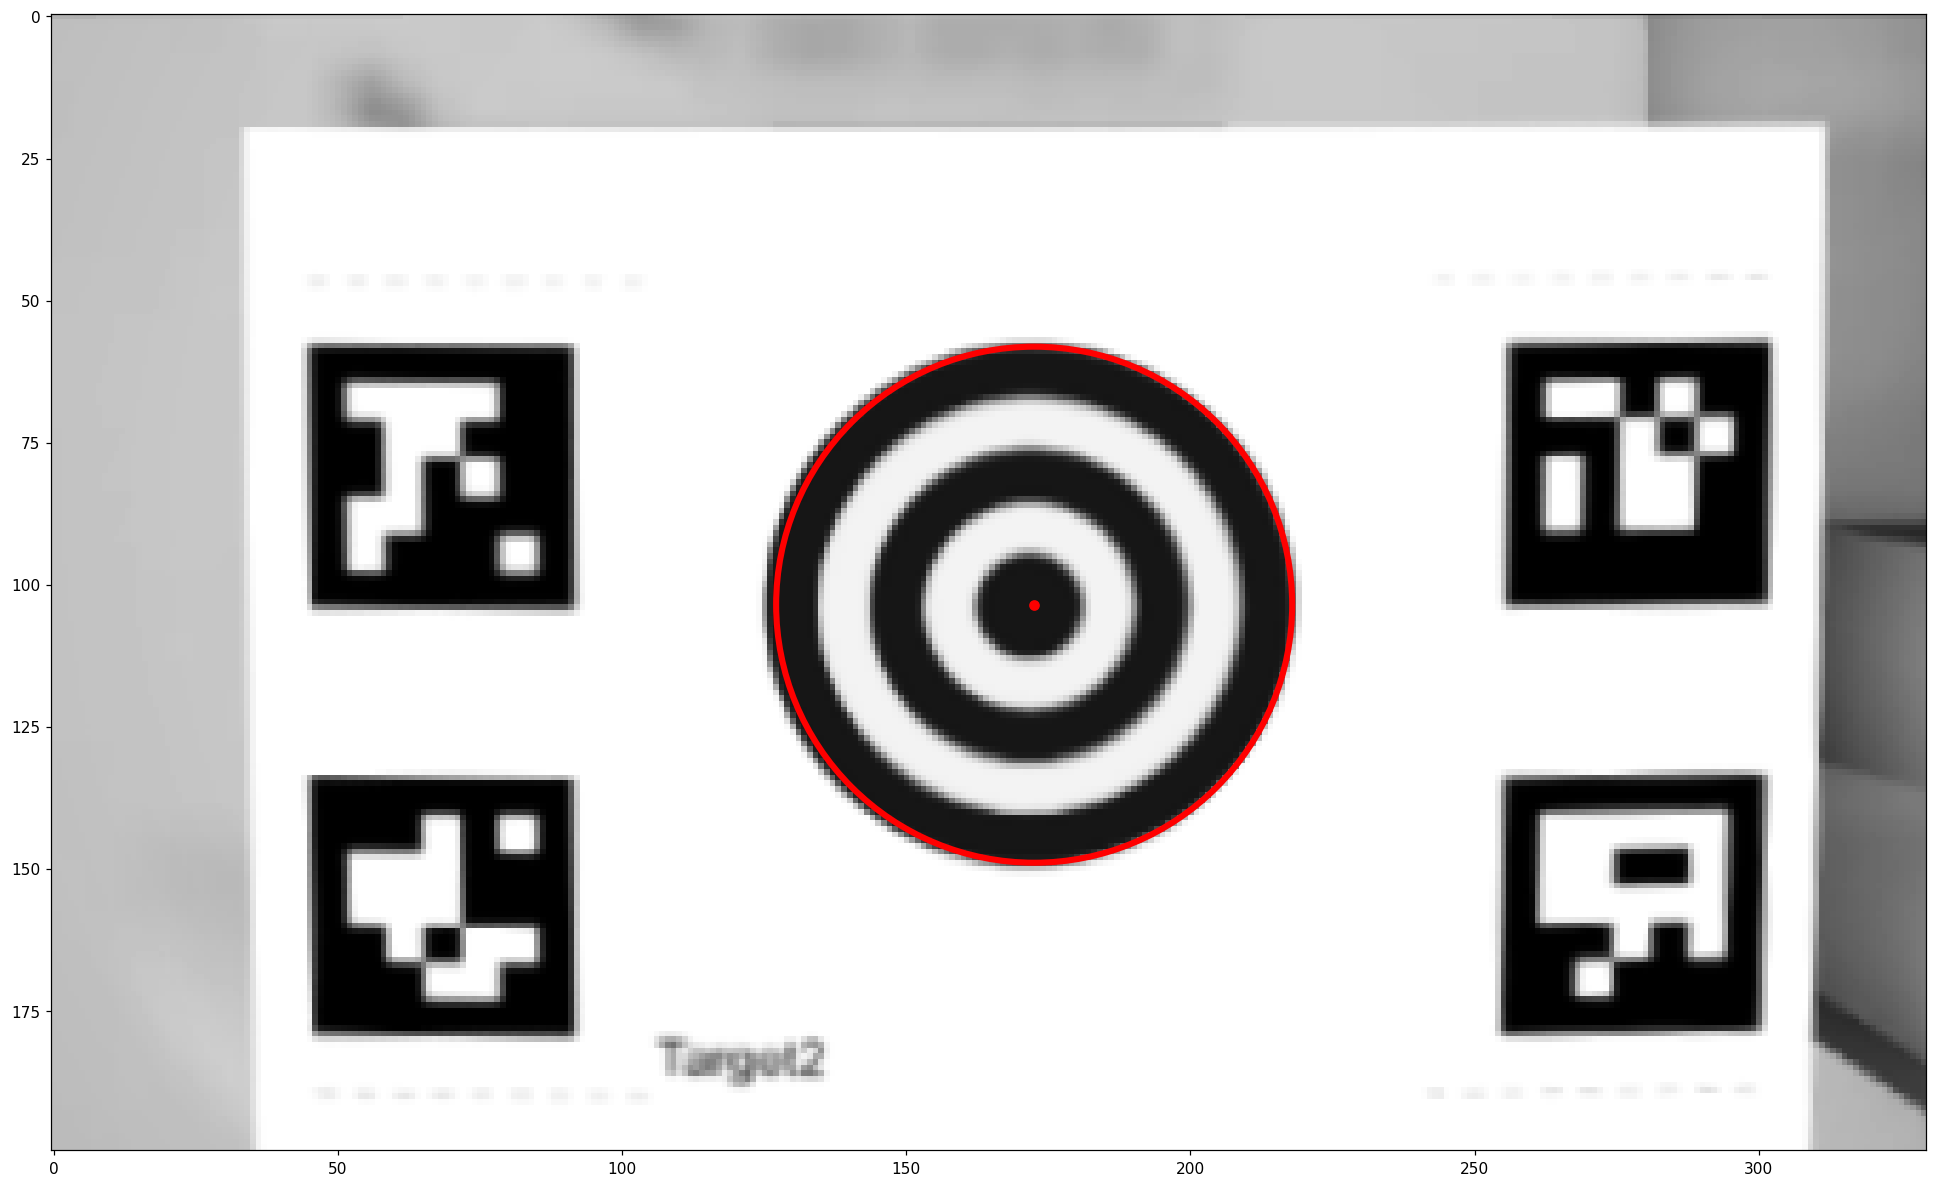

In [6]:
# Show Image
fig = plt.figure(figsize=(22, 22), dpi=110)
ax = fig.add_subplot()
ax.scatter(center[0], center[1], c="red")
ax.imshow(ud_img, cmap="gray")
# add circle patch to ax
circle = plt.Circle(center[:2], center[2], fill=False, edgecolor="red", lw=4)
ax.add_patch(circle)

In [7]:
#
center[0] += crop_x
center[1] += crop_y
center

array([672.5, 603.5,  45.4], dtype=float32)

### 2. Calculate world position using meter/pixel aprroximation

#### Use meter/pixel approximation
AR tag in realworld is 0.05 m width and height so we use this information to calculate $C$ (meter/pixel constant) \
$C$ (meter/pixel) $= \frac{0.05}{\text{s_len}}$

In [8]:
# reading AR tag
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
corners, ids, _ = cv2.aruco.detectMarkers(
    ud_img, aruco_dict
)  # using the same image from above

In [9]:
# calculate average size of AR tag
s_len = 0
for i in range(len(corners)):
    c = corners[i][0]
    s1 = distance(c[0][0], c[0][1], c[1][0], c[1][1])
    s2 = distance(c[1][0], c[1][1], c[2][0], c[2][1])
    s3 = distance(c[2][0], c[2][1], c[3][0], c[3][1])
    s4 = distance(c[3][0], c[3][1], c[0][0], c[0][1])
    s_avg = sum([s1, s2, s3, s4]) / 4
    s_len += s_avg

s_len /= 4
s_len

45.25975353391218

In [10]:
# calculate meter/pixel
meter_px = 0.05 / s_len
meter_px

0.001104734252751422

Calculating world cordinate by using difference from camera center

In [11]:
cx, cy = 635.434258, 500.335102  # this is from camera matrix
xdist = center[0] - cx
ydist = center[1] - cy
xdist, ydist

(37.065742, 103.164898)

In [12]:
# convert to meter
xdist *= meter_px
ydist *= meter_px
# target distance
target_dist = abs(
    -10.581 - (-9.922840 - 0.1177)
)  # target_y - (astrobee_pos + navcam_offset)
target_dist

xdist, ydist, target_dist

(0.040947794791047, 0.11396979650220666, 0.5404599999999995)

In [13]:
# subtract nav cam offset
xc = xdist - 0.0422
yc = -ydist + 0.0826
xc, yc

(-0.001252205208953, -0.03136979650220666)

## Calulate angle to turn

In [14]:
t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)

#### YZ plane

In [15]:
pivot_angle = math.atan(0.1302 / 0.1111) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.435184375290124, 139.52578704032607)

In [16]:
d = math.sqrt(0.1302**2 + 0.1111**2)
l = math.sqrt(t_l**2 + yc**2)
l_p = math.sqrt((t_l - 0.1302) ** 2 + (yc - 0.1111) ** 2)
l, d, l_p

(0.6589071632123816, 0.1711585522257068, 0.5468449547315755)

In [17]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.7540351077270114, 0.536986408815324, 0.21704869891168743)

In [18]:
turn_angle = angle1 - angle2
print(f"∠x : {turn_angle} , {math.degrees(turn_angle)}°")

∠x : 0.21704869891168743 , 12.435974396445435°


#### XY plane

In [19]:
pivot_angle = math.atan(0.1302 / 0.0572) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.727652176143348, 156.28295767268844)

In [20]:
d = math.sqrt(0.0572**2 + 0.1302**2)
l = math.sqrt((xc) ** 2 + t_l**2)
l_p = math.sqrt((xc - 0.0572) ** 2 + (t_l - 0.1302) ** 2)
l, d, l_p

(0.6581611912122164, 0.14221068876846074, 0.5311858637932567)

In [21]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.41584305994619286, 0.32692189717568687, 0.08892116277050599)

In [22]:
turn_angle = angle1 - angle2
print(f"∠y : {turn_angle} , {math.degrees(turn_angle)}°")

∠y : 0.08892116277050599 , 5.0948073361458155°


## Handle navigation errors

Parameters: Retry count $x$, Angle threshold $\theta$

Retry $x$ times. \
Each time check if result orientation and expected orientation angle different is more than $\theta$ or not



### Some Experiments

In [23]:
def x_angle(x, y):
    laser = [0.1302, 0.1111]
    pivot_angle = math.atan(laser[0] / laser[1]) + math.radians(90)
    d = math.sqrt(laser[0] ** 2 + laser[1] ** 2)
    l = math.sqrt(x**2 + y**2)
    l_p = math.sqrt((x - laser[0]) ** 2 + (y - laser[1]) ** 2)
    angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
    angle2 = (
        math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)
    )

    return angle1 - angle2


def y_angle(x, y):
    laser = [0.0572, 0.1302]
    pivot_angle = math.atan(laser[1] / laser[0]) + math.radians(90)
    d = math.sqrt(laser[0] ** 2 + laser[1] ** 2)
    l = math.sqrt(x**2 + y**2)
    l_p = math.sqrt((x - laser[0]) ** 2 + (y - laser[1]) ** 2)
    angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
    angle2 = (
        math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)
    )

    return angle1 - angle2

In [71]:
origin = 0
diff = 0
i = 0
while diff < 0.02:
    # if (i == 100000): break
    t_angle = x_angle(t_l, yc - (i * 10e-9))
    if i == 0:
        origin = t_angle
    diff = t_angle - origin
    # print(f"∠y : {t_angle} , {math.degrees(t_angle)}°", f"diff: {diff}", )
    i += 1

diff, -(i * 10e-9), i

(0.02000001225390957, -0.013339430000000001, 1333943)

In [77]:
x_angle(t_l, yc - 0.016) - origin - 0.019

0.004974702335924692

In [52]:
origin = 0
diff = 0
i = 0
while diff < 0.03:
    # if (i == 100000): break
    t_angle = y_angle(xc - (i * 10e-9), t_l)
    if i == 0:
        origin = t_angle
    diff = t_angle - origin
    # print(f"∠y : {t_angle} , {math.degrees(t_angle)}°", f"diff: {diff}", )
    i += 1

diff, -(i * 10e-9), i

(0.030000002535410242, -0.01978116, 1978116)

In [80]:
y_angle(xc - 0.019, t_l) - y_angle(xc, t_l) - 0.03

-0.0011824576647387064

In [79]:
y_angle(xc - 0.0197811, t_l) - y_angle(xc, t_l)

0.029999926855026005

#### Plotting Contour Graph

In [26]:
# contour from point around x, y
def contour_from(x, y, f, offset=0.2):
    xv = np.linspace(x - offset, x + offset, 100)
    yv = np.linspace(y - offset, y + offset, 100)
    X, Y = np.meshgrid(xv, yv, indexing="ij")
    Z = np.empty_like(X)

    for i in range(len(xv)):
        for j in range(len(yv)):
            Z[i][j] = f(X[i][j], Y[i][j])

    return X, Y, Z

<AxesSubplot:title={'center':'x_angle'}, xlabel='length to target', ylabel='yc'>

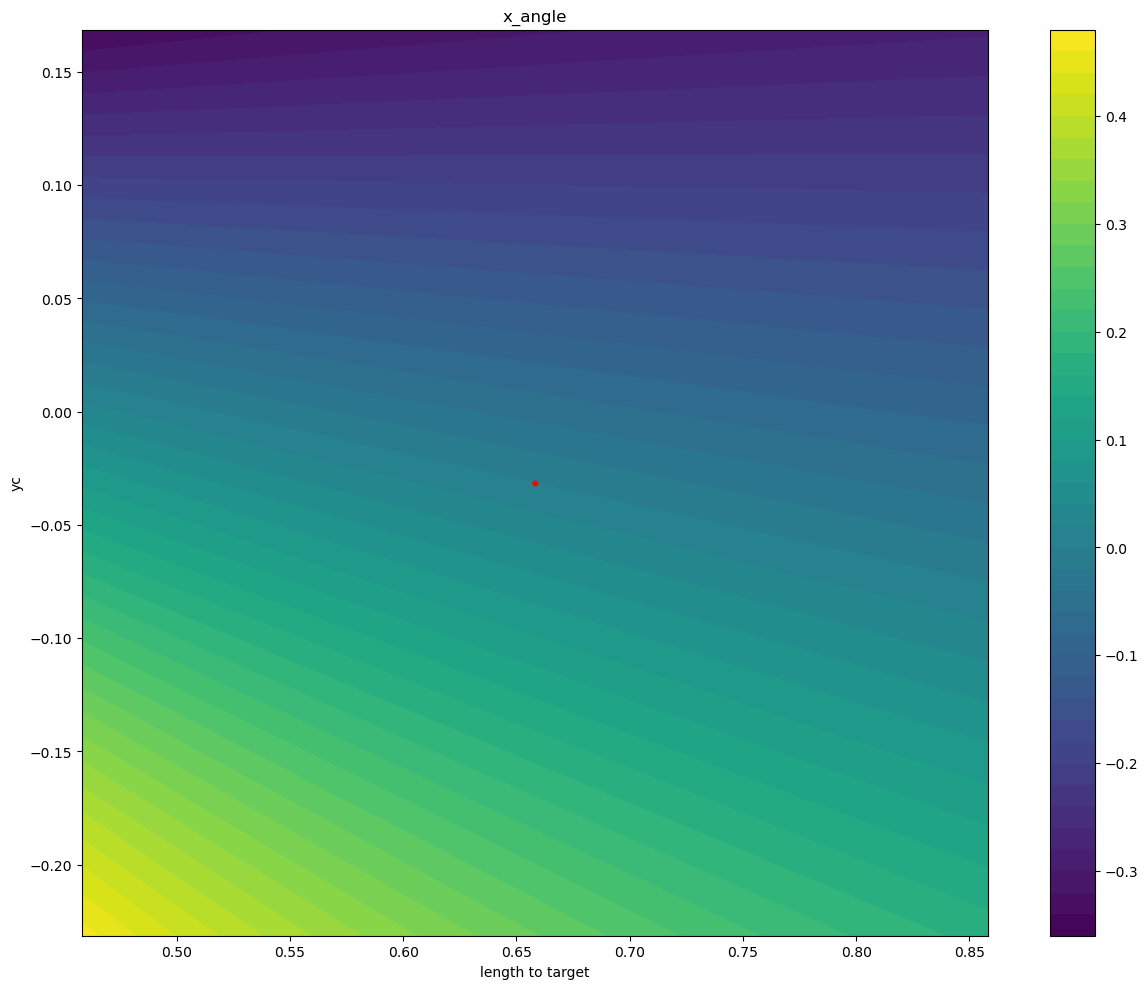

In [27]:
# contour graph
%matplotlib inline


def f(x, y):
    return x_angle(x, y) - x_angle(t_l, yc)


X, Y, Z = contour_from(t_l, yc, f)

fig = plt.figure(figsize=(16, 12), dpi=100)
ax = fig.add_subplot()
plt.contourf(X, Y, Z, 50)
ax.axis("scaled")
ax.scatter(t_l, yc, c="red", s=10)
ax.set_title("x_angle")
ax.set_xlabel("length to target")
ax.set_ylabel("yc")
plt.colorbar()

ax

<AxesSubplot:title={'center':'y_angle'}, xlabel='xc', ylabel='length to target'>

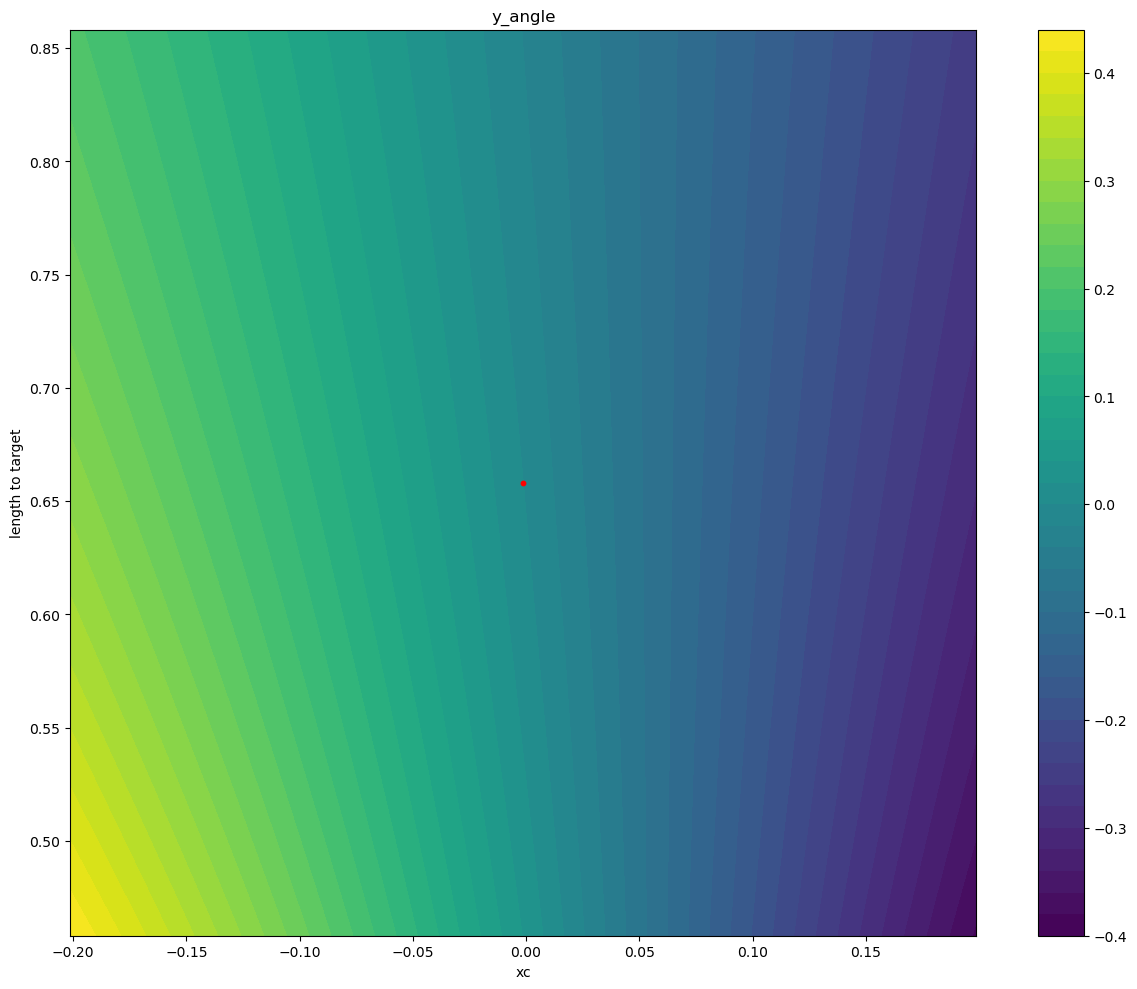

In [28]:
# contour graph
%matplotlib inline


def f(x, y):
    return y_angle(x, y) - y_angle(xc, t_l)


X, Y, Z = contour_from(xc, t_l, f)

fig = plt.figure(figsize=(16, 12), dpi=100)
ax = fig.add_subplot()
plt.contourf(X, Y, Z, 50)
ax.axis("scaled")
ax.scatter(xc, t_l, c="red", s=10)
ax.set_title("y_angle")
ax.set_xlabel("xc")
ax.set_ylabel("length to target")
plt.colorbar()

ax

In [42]:
arr = []
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        if Z[i][j] > 0.029 and Z[i][j] <= 0.03:
            arr.append((X[i][j], Y[i][j]))
arr = np.array(arr)

array([0.85007919, 0.8541196 , 0.81775596, 0.78139232, 0.78543273,
       0.74906909, 0.71270545, 0.71674586, 0.68038222, 0.64805899,
       0.61169535, 0.61573576, 0.57937212, 0.54704889, 0.51068525,
       0.47836202])

Text(0, 0.5, 'length to target')

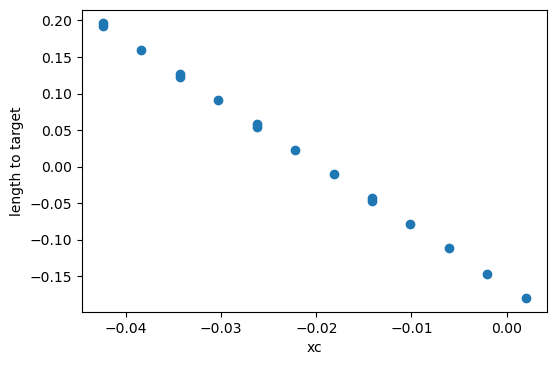

In [30]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
ax.scatter(arr[:, 0] - xc, arr[:, 1] - t_l)
ax.set_xlabel("xc")
ax.set_ylabel("length to target")

In [31]:
p = (
    0.6581599999999987,
    -0.06541473359921945,
)
x_angle(p[0], p[1] + 0.001) - x_angle(p[0], p[1])

-0.001479457557554742